In [9]:
import sys
sys.path.append('C:/Users/iaaraya/Documents/CIARP/Wind_speed/data/')
sys.path.append('C:/Users/iaaraya/Documents/CIARP/Wind_speed/model_and_functions/')
sys.path.append('/home/iaraya/CIARP/data/')
sys.path.append('/home/iaraya/CIARP/model_and_functions/')
from keras.layers import SimpleRNN, LSTM, Input, Dense, Lambda, GaussianNoise, Bidirectional
from keras.models import Model
from keras.optimizers import Adadelta,SGD, Adam
#from multiplicative_lstm import MultiplicativeLSTM
import numpy as np
import pandas as pd
#from data_processing2 import get_data
import matplotlib.pyplot as plt
import simple_LSTM as sLSTM
import LSTM_Ms as Ms
import data_processing
from importlib import reload
reload(data_processing)
import copy
import os

In [27]:
time_steps = 24
lag = 1

In [28]:
training_inputs, validation_inputs, testing_inputs, training_outputs, validation_outputs,\
        testing_outputs,vmins, vmaxs = data_processing.get_data('data/', 'no_mvs_b08.csv', time_steps, lag, overlap=False, number_of_sets=1)

19536
19536
5860


In [39]:
print(len(training_inputs[0]), len(validation_inputs[0]), len(testing_inputs[0]))

62609 3479 3479


In [120]:
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES']='0' # gpu='0' o gpu='1'
###################################
config = tf.ConfigProto()
config.gpu_options.allow_growth = True#Utiliza la memoria que necesita de manera dinamica, puede ser o no en bloque.
config.gpu_options.per_process_gpu_memory_fraction = 0.5#20%de la ram,
session = tf.Session(config=config)
########

In [91]:
# Create the model
Ms_model = Ms.LSTM_Ms([1,24],[24,4],[1],[1,10],[20,20],0.001,0)



epochs = 10
results = np.zeros((epochs,120))
for epoch in range(epochs):
    Ms_model.fit(training_inputs[0], training_outputs[0],epochs=5)
    N = len(validation_inputs[0])
    sims = 20
    outputs = np.zeros((sims,120,N))
    for j in range(sims):
        print(j)
        data = []
        for i in range(120):
            noise = np.random.normal(0,0.2,size=(N,1))
            temp_data = copy.deepcopy(validation_inputs[0])
            temp_data[:,i] = temp_data[:,i] + noise            
            data.append(temp_data)

        data = np.concatenate(data)
        outputs[j,:,:]  = Ms_model.predict(data).reshape(120,N)
    results[epoch,:] = np.mean(np.std(outputs,axis=0),axis=1)
    #Ms_model.predict()
    np.savetxt("long_term_analysis.txt",results)

In [161]:
mse_results = np.zeros((11))
overall_results = np.zeros((11,200))
for k in range(3,11):
    mse = []
    for r in range(5):
        sims = 1
        padding = 10*k
        length = 24+padding
        # Generate data and train the model
        if padding == 0:
                data = copy.deepcopy(training_inputs[0])
                outputs = copy.deepcopy(training_outputs[0]) 
                dimension = length

        else:
            N = len(training_inputs[0])
            data = []
            outputs = []
            for i in range(sims):
                temp_data = copy.deepcopy(training_inputs[0]).reshape(N,-1)
                noise = np.random.normal(0.5,0.2,size=(N,padding))
                temp_data = np.concatenate((temp_data,noise),axis=1) 
                if (padding+24)%24 != 0:
                    zeros = np.zeros((N,24-(padding+24)%24))
                    temp_data = np.concatenate((zeros,temp_data),axis=1) 
                data.append(temp_data)
                outputs.append(training_outputs[0])
            data = np.concatenate(data)
            outputs = np.concatenate(outputs)
            dimension = length + 24-length%24


        Ms_model = Ms.LSTM_Ms([1,24],[24,int(dimension/24)],[1],[1,10],[20,20],0.001,0)

        Ms_model.fit(data.reshape(-1,dimension,1),outputs,epochs=10)
        # test what the model learns
        # Validation input is padded
        if padding > 0:
            sims = 1
            N = len(validation_inputs[0])
            data = []
            outputs = []
            for i in range(sims):
                noise = np.random.normal(0.5,0.2,size=(N,padding))
                temp_data = copy.deepcopy(validation_inputs[0]).reshape(N,-1)
                temp_data = np.concatenate((temp_data,noise),axis=1)  
                if (padding+24)%24 != 0:
                    zeros = np.zeros((N,24-(padding+24)%24))
                    temp_data = np.concatenate((zeros,temp_data),axis=1) 
                data.append(temp_data)
            data = np.concatenate(data)
        else:
            data = copy.deepcopy(validation_inputs[0].reshape(-1,24))

        mse.append(Ms_model.evaluate(data.reshape(-1,dimension,1),validation_outputs[0][:,0]))
        print(mse_results[k])
        # Validation inputs are modified
        N = len(data)
        sims = 10
        outputs = np.zeros((sims,length,N))
        if r == 0:
            for j in range(sims):
                print(j)
                data2 = []
                for i in range(length):
                    noise = np.random.normal(0,0.2,size=(N))
                    temp_data = copy.deepcopy(data)
                    temp_data[:,i] = temp_data[:,i] + noise 
                    #if (padding+24)%24 != 0:
                    #    zeros = np.zeros((N,24-(padding+24)%24))
                    #    temp_data = np.concatenate((zeros,temp_data),axis=1) 
                    data2.append(temp_data)

                data2 = np.concatenate(data2).reshape(-1,dimension,1)
                outputs[j,:,:]  = Ms_model.predict(data2).reshape(length,N)
            results = np.mean(np.std(outputs,axis=0),axis=1)
            overall_results[k,-length:] = results
            #Ms_model.predict()

            np.savetxt("long_term_analysis_Ms_LSTM10.txt",overall_results)
    mse_results[k] = np.mean(mse)
    np.savetxt("mse_long_term_Ms_LSTM10.txt",mse_results)
    

Epoch 1/10
17537/17537 [==============================] - 14s 782us/step - loss: 0.0329
Epoch 2/10
17537/17537 [==============================] - 8s 459us/step - loss: 0.0155
Epoch 3/10
10048/17537 [================>.............] - ETA: 3s - loss: 0.0129- ETA: 4s - loss: 

KeyboardInterrupt: 

In [160]:
length

27

mse_results = np.zeros((11))
overall_results = np.zeros((11,35))
for k in range(0,11):   
    sims = 1
    padding = k
    
    # Generate data and train the model
    if padding == 0:
            data = copy.deepcopy(training_inputs[0])
            outputs = copy.deepcopy(training_outputs[0])  
    else:
        N = len(training_inputs[0])
        data = []
        outputs = []
        for i in range(sims):
            temp_data = copy.deepcopy(training_inputs[0]).reshape(N,-1)
            noise = np.random.normal(0.5,0.2,size=(N,padding))
            temp_data = np.concatenate((temp_data,noise),axis=1) 
            #if (padding+24)%24 != 0:
            #    zeros = np.zeros((N,24-(padding+24)%24))
            #    temp_data = np.concatenate((zeros,temp_data),axis=1) 
            data.append(temp_data)
            outputs.append(training_outputs[0])
        data = np.concatenate(data)
        outputs = np.concatenate(outputs)
    
    length = 24+k
    smodel = sLSTM.model([20,20,20],lag,length,0,0.1)
    smodel.fit(data.reshape(-1,length,1),outputs,epochs=10)
    # test what the model learns
    # Validation input is padded
    if padding > 0:
        sims = 1
        N = len(validation_inputs[0])
        data = []
        outputs = []
        for i in range(sims):
            noise = np.random.normal(0.5,0.2,size=(N,padding))
            temp_data = copy.deepcopy(validation_inputs[0]).reshape(N,-1)
            temp_data = np.concatenate((temp_data,noise),axis=1)     
            data.append(temp_data)
        data = np.concatenate(data)
    else:
        data = copy.deepcopy(validation_inputs[0].reshape(-1,24))

    mse_results[k] = smodel.evaluate(data.reshape(-1,length,1),validation_outputs[0][:,0])
    # Validation inputs are modified
    N = len(data)
    sims = 10
    outputs = np.zeros((sims,length,N))
    for j in range(sims):
        print(j)
        data2 = []
        for i in range(length):
            noise = np.random.normal(0,0.2,size=(N))
            temp_data = copy.deepcopy(data)
            temp_data[:,i] = temp_data[:,i] + noise            
            data2.append(temp_data)

        data2 = np.concatenate(data2).reshape(-1,length,1)
        outputs[j,:,:]  = smodel.predict(data2).reshape(length,N)
    results = np.mean(np.std(outputs,axis=0),axis=1)
    overall_results[k,-length:] = results
    #Ms_model.predict()
    #np.savetxt("long_term_analysis2.txt",overall_results)
    np.savetxt("long_term_analysis_LSTM.txt",overall_results)
    np.savetxt("mse_long_term_LSTM.txt",mse_results)

length = 24
padding = 0
if padding > 0:
    sims = 1
    N = len(validation_inputs[0])
    data = []
    outputs = []
    for i in range(sims):
        noise = np.random.normal(0,0.2,size=(N,padding))
        temp_data = copy.deepcopy(validation_inputs[0]).reshape(N,-1)
        temp_data = np.concatenate((temp_data,noise),axis=1)     
        if (padding+24)%24 != 0:
            noise2 = np.random.normal(0,0.2,size=(N,24-(padding+24)%24))
            temp_data = np.concatenate((noise2,temp_data),axis=1) 
        data.append(temp_data)
    data = np.concatenate(data)
else:
    data = copy.deepcopy(validation_inputs[0].reshape(-1,24))


N = len(data)
sims = 10
outputs = np.zeros((sims,length,N))
for j in range(sims):
    print(j)
    data2 = []
    for i in range(length):
        noise = np.random.normal(0,0.2,size=(N))
        temp_data = copy.deepcopy(data)
        temp_data[:,i] = temp_data[:,i] + noise            
        data2.append(temp_data)

    data2 = np.concatenate(data2).reshape(-1,length,1)
    outputs[j,:,:]  = smodel.predict(data2).reshape(length,N)
results = np.mean(np.std(outputs,axis=0),axis=1)
#Ms_model.predict()
#np.savetxt("long_term_analysis.txt",results)

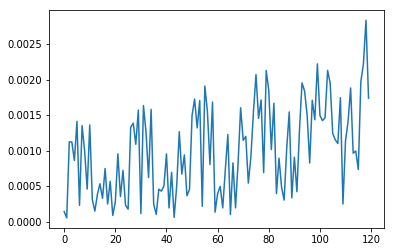

In [22]:
variability = np.mean(np.std(tpredictions,axis=2),axis=2)
variability2 = np.mean(np.std(tpredictions2,axis=2),axis=2)

plt.figure(figsize=(8,6))
ax =plt.subplot(111)
for i in range(10):
    plt.plot(variability[i])
    #plt.plot(variability2[i])

ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("Variability", fontsize=16)
plt.xlabel("Variability", fontsize=16)


plt.show()

In [81]:
Ms_model.fit(training_inputs[0], training_outputs[0], epochs=50,validation_data=(validation_inputs[0],validation_outputs[0][:,0]))

Train on 6296 samples, validate on 353 samples
Epoch 1/50
6296/6296 [==============================] - 4s 609us/step - loss: 0.0355 - val_loss: 0.0111
Epoch 2/50
6296/6296 [==============================] - 1s 190us/step - loss: 0.0146 - val_loss: 0.0071
Epoch 3/50
6296/6296 [==============================] - 1s 172us/step - loss: 0.0105 - val_loss: 0.0062
Epoch 4/50
6296/6296 [==============================] - 2s 277us/step - loss: 0.0092 - val_loss: 0.0059
Epoch 5/50
6296/6296 [==============================] - 1s 206us/step - loss: 0.0084 - val_loss: 0.0055
Epoch 6/50
6296/6296 [==============================] - 1s 188us/step - loss: 0.0080 - val_loss: 0.0051
Epoch 7/50
6296/6296 [==============================] - 1s 208us/step - loss: 0.0077 - val_loss: 0.0049
Epoch 8/50
6296/6296 [==============================] - 1s 188us/step - loss: 0.0073 - val_loss: 0.0047
Epoch 9/50
6296/6296 [==============================] - 2s 259us/step - loss: 0.0072 - val_loss: 0.0047
Epoch 10/50
6296/

KeyboardInterrupt: 

(353, 240, 1)